# Readme
Reads the raw AIN1 ADC value on the Beaglebone Green<br>
Samples at approximately 1kHz (some overhead due to the OS, Python, no RTOS, etc.)<br>
Saves a JSON file of the data in samples/<br>
And plots a graph for visual verification of results (i.e. not too noisy, or missed movement)

## Beaglebone dependencies
Python 3.7.3 or higher<br>
`python3 -m pip install numpy==1.20 matplotlib jupyterlab`

## How to guide
1. Make sure the EMG sensor is properly connected, then connect the Beaglebone to the PC, wait for it to boot up (~1min)
2. Open a terminal and SSH into the beaglebone with: `ssh -L 8888:localhost:8888 debian@192.168.7.2`
3. Password is: **temppwd**
4. Start the jupyter server on the beaglebone with the command: `jupyter lab`
5. Copy the URL (localhost ... or, 127.0.0.1 ...) and paste it in a browser to open the jupyter environment, for example:<br>
    `http://localhost:8888/lab?token=389adbadce2bae7df571cf9f9d8c0ec12db68db033b7a1ab`
6. Run the Imports cell (mark it and hit `shift + enter`)

7. Open Cloud9 (http://192.168.7.2/) or SSH (`ssh debian@192.168.7.2`) to the beaglebone and check what files are in ~/samples/<br>
    I.e., currently the files are saved as "Number" + "Finger" + "movement" + "json", for example: "1ThumbFlexion.json"<br>
    **Dont overwrite data or new samples needs to be collected!**

8. Start sampling! For example: 10 x Thumb Flexion, 10 X Thumb Extension ... etc for all fingers where:<br>
    You need to **manually change `sample`** (and after 10 x the `movement` and `label`) in between collecting the data :(<br>
    Check graph that readings are OK! Might need to change electrode position, disconnect power from PC, etc.<br>
    <img src="sensorPlace2.jpg" width="600" height="400"><br>
    <img src="sensorPlace3.jpg" width="600" height="400"><br>
    ~3.5 cm from center to center of electrodes

9. After sampling is done, compress and archive the samples directory with the command, from the ~ directory: `tar -zcvf jsonData.tar.gz samples`

10. Copy the .tar.gz JSON data from the beaglebone to the PC, for example, in my terminal:<br>
    `scp debian@192.168.7.2:/home/debian/jsonData.tar.gz C:\Users\Seb\Desktop`

11. Open archive and unpack it on the PC --> We now have training data!

# Imports 

In [1]:
# Data collection
import time
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis,skew

# Sampling from ADC

# function definitions

In [6]:
! echo 10 > /sys/class/gpio/export;echo 9 > /sys/class/gpio/export;echo 8 > /sys/class/gpio/export

In [7]:
from time import sleep


PATH = "/sys/bus/gpio/devices/gpiochip0/gpio/"

# GPIO 10 for INDEX
# GPIO 9 for MIDDLE
# GPIO 8 for RING + LITTLE

# Set GPIO pins as output pins
try:
    f1 = open(PATH + "gpio10/direction", "w")
    f1.write("out") 
    f1.close()
    
    f1 = open(PATH + "gpio10/value", "w")
    f1.write("0") 
    f1.close()
    print("P8_31 set as OUTPUT")
    
    f2 = open(PATH + "gpio9/direction", "w")
    f2.write("out") 
    f2.close()
    print("P8_33 set as OUTPUT")
    
    f3 = open(PATH + "gpio8/direction", "w")
    f3.write("out") 
    f3.close()
    
    f1 = open(PATH + "gpio10/value", "w")
    f1.write("0") 
    f1.close()
    print("P8_35 set as OUTPUT")
except:
    print("ERROR setting GPIOs as out")
    pass




P8_31 set as OUTPUT
P8_33 set as OUTPUT
P8_35 set as OUTPUT


In [8]:
def feature_windows(data):
    window_size =250
    overlap = 50
    var    = lambda data : np.var(data,axis =1) 
    rms    = lambda data : np.sqrt(np.mean(data ** 2,axis =1))
    mav    = lambda data : np.sum(np.absolute(data),axis =1) / len(data)
    wl     = lambda data : np.sum(abs(np.diff(data)),axis =1)
    mean   = lambda data : np.mean(data,axis =1 )
    std    = lambda data : np.std(data,axis =1)
    median = lambda data : np.median(data,axis =1)
    peak   = lambda data : np.max(data,axis =1)
    min    = lambda data : np.min(data,axis =1)
    iemg   = lambda data : np.sum(abs(data),axis =1)
    aac    = lambda data : np.sum(abs(np.diff(data)),axis =1) / len(data)
    kur    = lambda data : kurtosis(data,axis =1)
    skewe  = lambda data : skew(data,axis =1)
    features = [var,rms,mav,wl,mean,std,median,peak,min,iemg,aac,kur,skewe]
    
    win_matrix = sliding_window(data, window_size, overlap)
    feature_vector = []
    for feature_func in features:
        feature_vector.extend(feature_func(win_matrix))
    return np.array(feature_vector)

In [9]:
v = lambda x_t : x_t[1:] * x_t[1:] - x_t[0:-1] * x_t[1:]
mx_t = lambda x_t : np.convolve(x_t,np.ones(50))/50

In [10]:
def sliding_window(data, window_size, overlap):
    """
    Applies a sliding window with overlap to the input data.

    Parameters:
    data (ndarray): input data
    window_size (int): size of sliding window
    overlap (int): overlap between consecutive windows

    Returns:
    ndarray: 2D array with sliding windows of shape (n_windows, window_size)
    """
    n_samples = data.shape[0]
    overlap = int(np.floor((window_size*overlap)/100))
    n_windows = int(np.floor((n_samples - window_size) / overlap) + 1)
    windows = np.zeros((n_windows, window_size))

    for i in range(n_windows):
        start = i * overlap
        end = start + window_size
        windows[i] = data[start:end]

    return windows

# sampling 


Sampled 1000 samples in 0.9972214698791504 s
Sample rate: 998


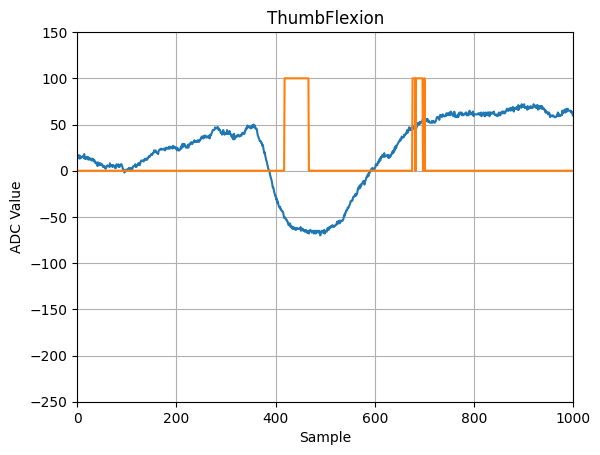

In [6]:
np.set_printoptions(suppress=True) # No scientific notation

# Raw analog input pin to read from file
pin = 1
file = "/sys/bus/iio/devices/iio:device0/in_voltage{}_raw".format(pin)
fd = open(file, "r")

########## CHANGE DEPENDING ON: FINGER, MOVEMENT, AMOUNT, SAMPLE NO ########## 
label = "Thumb" # "Thumb" or "Index" or "Middle" or "Ring" or "Pinky"
movement = "Flexion" # "Extension" or "Flexion"
sampleCount = 1000 # Amount of samples needed
sample = 2 # Increment manually, i.e., set to 1 first, then 2, 3 ...
############################################################################# 

sampleStart = sampleCount # For printouts
period = 0.001 # Sample period
data = [] # List of samples
t = time.time() # For controlling sample rate
startLoopTime = time.time() # For verification of sample rate accuracy

while True:
    t += period
    fd.seek(0) # Reset file pinter to begining of file
    value = float(fd.read().strip()) - 3412.0 # Read sensor value as float, CAN test with offset * 1.8/4096.0
    data.append(value) # Append sensor value to list
    time.sleep(max(0,t-time.time())) # Adjust sleep to get better time precision
    sampleCount -= 1
    if (sampleCount == 0): break # Change value to sample more
fd.close()

#Some information how it went
print("\nSampled " + str(sampleStart) + " samples in " + str(time.time() - startLoopTime) + " s")
print("Sample rate: " + str(1000 / (time.time() - startLoopTime) ).split('.')[0])

#Saving the data as a JSON file
jsonFileName = str(sample) + label + movement
jsonStructure = {'label': label, 'data': data}
with open("samples/" + jsonFileName + ".json", 'w') as f:
    json.dump(jsonStructure, f, indent = 4)

#Plotting the data

plt.plot(data)
plt.plot(100*(20 < v(mx_t(data))))
plt.xlabel('Sample')
plt.ylabel('ADC Value')
plt.title(label + movement)
plt.xlim(0, 1000)
plt.ylim(-250, 150) #SHOULD be enough to contain min/max ADC values from our experiments, COULD be adjusted. Can test with (-2, 2) if using *1.8/4096.0 offset
plt.grid(True)

# Loading the model and making predictions


In [11]:
import pickle

In [12]:
with open(r"rf_3_pipe.sav", "rb") as input_file:
    trainedModel = pickle.load(input_file)


Sampled 1000 samples in 1.0006415843963623 s
Sample rate: 999
MiddleFlexion
P8_33 sent 1
P8_33 sent 0


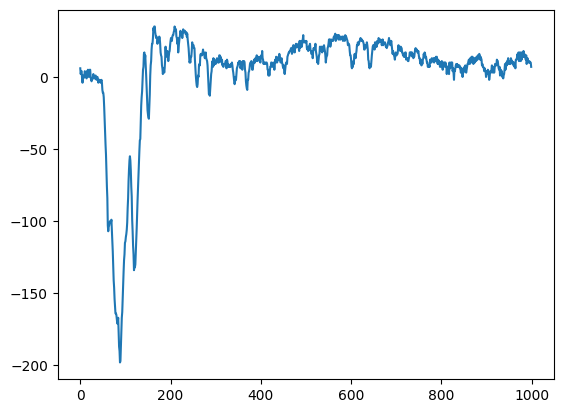

In [34]:
# Raw analogRF_pipeLine.savnput pin to read from file
pin = 1
file = "/sys/bus/iio/devices/iio:device0/in_voltage{}_raw".format(pin)
sampleCount = 1000 
sampleStart = sampleCount # For printouts
period = 0.001 # Sample period
data = [] # List of samples
t = time.time() # For controlling sample rate
startLoopTime = time.time() # For verification of sample rate accuracy
fd = open(file, "r")
sampleCount = 1000 
while True:
    t += period
    fd.seek(0) # Reset file pinter to begining of file
    value = float(fd.read().strip()) - 3412.0 # Read sensor value as float, CAN test with offset * 1.8/4096.0
    data.append(value) # Append sensor value to list
    time.sleep(max(0,t-time.time())) # Adjust sleep to get better time precision
    sampleCount -= 1
    if (sampleCount == 0): break # Change value to sample more
timeEnd = time.time()
fd.close()
data = np.array(data)
#Some information how it went
print("\nSampled " + str(sampleStart) + " samples in " + str(timeEnd - startLoopTime) + " s")
print("Sample rate: " + str(1000 / (timeEnd - startLoopTime) ).split('.')[0])

features =feature_windows(data)
preds= trainedModel.predict(features.reshape((1,-1)))[0]
plt.plot(data)
print(preds)
if preds == "IndexFlexion":
    try:
        f1 = open(PATH + "gpio10/value", "w")
        f1.write("1") 
        print("P8_31 sent 1")
        f1.close()
        sleep(1)
        f1 = open(PATH + "gpio10/value", "w")
        f1.write("0")
        print("P8_31 sent 0")
        f1.close()
    except:
        print("ERROR: P8_31 could not send value")
        pass
elif preds == 'MiddleFlexion':
    try:
        f2 = open(PATH + "gpio9/value", "w")
        f2.write("1") 
        print("P8_33 sent 1")
        f2.close()
        sleep(1)
        f2 = open(PATH + "gpio9/value", "w")
        f2.write("0")
        print("P8_33 sent 0")
        f2.close()
    except:
        print("ERROR: P8_33 could not send value")
        pass
elif preds in ['RingFlexion','LittleFlexion']:
    try:
        f3 = open(PATH + "gpio8/value", "w")
        f3.write("1") 
        print("P8_35 sent 1")
        f3.close()
        sleep(1)
        f3 = open(PATH + "gpio8/value", "w")
        f3.write("0")
        print("P8_35 sent 0")
        f3.close()
    except:
        print("ERROR: P8_35 could not send value")
        pass